In [1]:
import torch
from itertools import combinations
import numpy as np
import torch.nn.functional as F
from typing import List, Tuple, Dict, Any
import matplotlib.pyplot as plt

In [2]:
from fuzz.utils import enumerate_permute, gap_count
from fuzz.src.capacity import *
from fuzz.src.norm import *
from fuzz.src.choquet import *
from fuzz.src.sim import *
from fuzz.src.knn import *
from fuzz.eval import FuzzLOO

### utils.py

In [3]:
x = torch.rand(25, 3)
print("done")
enum = enumerate_permute(x[0].unsqueeze(0))
print(enum)
print("shape", enum.shape)
gap_count(enum[0][0])

done
tensor([[[-1, -1, -1],
         [ 1, -1, -1],
         [ 0, -1, -1],
         [ 2, -1, -1],
         [ 1,  0, -1],
         [ 1,  2, -1],
         [ 0,  2, -1],
         [ 1,  0,  2]]])
shape torch.Size([1, 8, 3])


3

### capacity.py

In [4]:
mu = generate_capacity(enum[0])
for i in range(len(mu)):
    print(mu[i].get_capacity())

print(f"Capacity locator for {enum[0][4]}:", locate_capacity(enum[0][4], mu))

0
0.03991276025772095
0.2978140711784363
0.34711939096450806
0.36431437730789185
0.7530539631843567
0.9656341671943665
1
Capacity locator for tensor([ 1,  0, -1]): 0.36431437730789185


### norm.py

In [5]:
normalized_x = normalize(x)
print("Normalized x:\n", normalized_x)

Normalized x:
 tensor([[0.1915, 0.0000, 1.0000],
        [0.0000, 0.5747, 1.0000],
        [0.0000, 0.5401, 1.0000],
        [1.0000, 0.2264, 0.0000],
        [0.0000, 1.0000, 0.0723],
        [0.0000, 0.4371, 1.0000],
        [0.0000, 0.0349, 1.0000],
        [0.7200, 1.0000, 0.0000],
        [0.1636, 0.0000, 1.0000],
        [1.0000, 0.0000, 0.6502],
        [0.0000, 1.0000, 0.4213],
        [1.0000, 0.8046, 0.0000],
        [0.0000, 1.0000, 0.9786],
        [1.0000, 0.6454, 0.0000],
        [0.0000, 0.4537, 1.0000],
        [1.0000, 0.0000, 0.2968],
        [0.4692, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.3984],
        [1.0000, 0.0000, 0.7868],
        [0.3728, 0.0000, 1.0000],
        [0.1489, 0.0000, 1.0000],
        [0.0000, 0.9789, 1.0000],
        [0.0000, 1.0000, 0.4567],
        [0.9205, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.1187]])


In [6]:
x2 = torch.rand(25,3)
x2

tensor([[0.0376, 0.3550, 0.6378],
        [0.4155, 0.0822, 0.7026],
        [0.8261, 0.2110, 0.3084],
        [0.4187, 0.5884, 0.1750],
        [0.3403, 0.3534, 0.2471],
        [0.9403, 0.5314, 0.7830],
        [0.5947, 0.8518, 0.9135],
        [0.0524, 0.5493, 0.9704],
        [0.2845, 0.9687, 0.1448],
        [0.8574, 0.7492, 0.5034],
        [0.5432, 0.9482, 0.7307],
        [0.8753, 0.8836, 0.9514],
        [0.1868, 0.4824, 0.9634],
        [0.6146, 0.1297, 0.5898],
        [0.9429, 0.0463, 0.4151],
        [0.0628, 0.7219, 0.7481],
        [0.2891, 0.7751, 0.6804],
        [0.1270, 0.5073, 0.9877],
        [0.6178, 0.7260, 0.5838],
        [0.4586, 0.4127, 0.0844],
        [0.5169, 0.8846, 0.3092],
        [0.4299, 0.4782, 0.6008],
        [0.2701, 0.1910, 0.5681],
        [0.1661, 0.7196, 0.4642],
        [0.8424, 0.0596, 0.5776]])

In [7]:
T_norm_result = T_conorm(x, x2, mode='L')
T_norm_result

tensor([[0.7545, 1.0000, 1.0000],
        [0.7589, 0.6269, 1.0000],
        [0.8399, 0.5440, 0.9131],
        [1.0000, 1.0000, 0.5444],
        [0.4540, 0.6288, 0.3725],
        [0.9431, 0.8802, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [0.8235, 1.0000, 1.0000],
        [0.4705, 1.0000, 0.7346],
        [1.0000, 1.0000, 1.0000],
        [0.7727, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [0.4177, 1.0000, 1.0000],
        [1.0000, 0.7450, 0.7503],
        [1.0000, 0.6033, 1.0000],
        [0.6059, 0.8896, 1.0000],
        [0.5652, 1.0000, 0.8353],
        [0.4067, 0.7638, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [0.8993, 0.6710, 0.8320],
        [0.6289, 0.9320, 0.7904],
        [0.6904, 0.9449, 1.0000],
        [0.6039, 0.8551, 1.0000],
        [1.0000, 0.7266, 1.0000],
        [1.0000, 0.9873, 1.0000]])

### choquet.py

In [8]:
s_union_result = s_triangle(x, x2, mode='M')
s_union_result

tensor([[0.7169, 0.6450, 0.3622],
        [0.4155, 0.5447, 0.3062],
        [0.8261, 0.3330, 0.6047],
        [0.5813, 0.5121, 0.3693],
        [0.3403, 0.3534, 0.2471],
        [0.9403, 0.5314, 0.2170],
        [0.5912, 0.5715, 0.0865],
        [0.7712, 0.4507, 0.6226],
        [0.2845, 0.8929, 0.5899],
        [0.1426, 0.5429, 0.4966],
        [0.5432, 0.2146, 0.5363],
        [0.1247, 0.1879, 0.6404],
        [0.2309, 0.5176, 0.2572],
        [0.3854, 0.6153, 0.5898],
        [0.5419, 0.5570, 0.5849],
        [0.5431, 0.7219, 0.7209],
        [0.2891, 0.5868, 0.6804],
        [0.2796, 0.5073, 0.7343],
        [0.3822, 0.5123, 0.4162],
        [0.4586, 0.4127, 0.7476],
        [0.5169, 0.8846, 0.4812],
        [0.4299, 0.4782, 0.5289],
        [0.3338, 0.6641, 0.5154],
        [0.8339, 0.7196, 0.5358],
        [0.6265, 0.9277, 0.5607]])

In [9]:
x[0]

tensor([0.7169, 0.6778, 0.8820])

In [10]:
enumerate_permute(x[0].unsqueeze(0))

tensor([[[-1, -1, -1],
         [ 1, -1, -1],
         [ 0, -1, -1],
         [ 2, -1, -1],
         [ 1,  0, -1],
         [ 1,  2, -1],
         [ 0,  2, -1],
         [ 1,  0,  2]]])

In [11]:
choquet = Choquet(X=x[0].unsqueeze(0), mu=mu)

In [12]:
choquet.choquet

0.7500029802322388

### sim.py

In [13]:
s_union_result = s_triangle(x, x2, mode='M')
s_union_result[0].unsqueeze(0)

tensor([[0.7169, 0.6450, 0.3622]])

In [14]:
choquet2 = Choquet(X=s_union_result[0].unsqueeze(0), mu=mu)
choquet2.choquet

0.6064812541007996

In [15]:
for i in range(5):
    sim = S1(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu)
    print("Sim1:", sim.score())
    sim = S2(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu)
    print("Sim2:", sim.score())
    sim = S3(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu)
    print("Sim3:", sim.score())
    print()

Sim1: 0.3594119254376427
Sim2: 0.33887921684676486
Sim3: 0.3154812629197109

Sim1: 0.3250580673318531
Sim2: 0.3298692216741722
Sim3: 0.3310077318039385

Sim1: 0.24481186629920776
Sim2: 0.2716417392478547
Sim3: 0.23995326120504767

Sim1: 0.3743626866367646
Sim2: 0.38184123207891524
Sim3: 0.3612155913507894

Sim1: 0.28293837925884074
Sim2: 0.29549672808194694
Sim3: 0.27656994693258297



### knn.py

In [16]:
label = torch.randint(0, 2, (25, ))

In [17]:
knn = KNNFuzz(input_dimension=3, mu=mu, k=3, sim=S1)
knn.fit(desc_set=x, label_set=label)
knn.accuracy(desc_set=x, label_set=label)

tensor(0.5600)

In [18]:
import time 
import copy

In [19]:
import torch
import time
import copy

def FuzzLOO(C, DS, mu, time_counter=False):
    """
    Perform Leave-One-Out cross-validation for a classifier.

    Args:
        C: Classifier class (must have fit() and accuracy() methods)
        DS: Tuple (X, Y) where X is a tensor of descriptions and Y is a tensor of labels
        mu: List of Capacity objects for fuzzy similarity
        time_counter (bool): If True, measure the execution time

    Returns:
        float: Accuracy over all leave-one-out runs
    """
    correct = 0
    X, Y = DS

    if time_counter:
        tic = time.time()

    for i in range(X.size(0)):
        # Split into train and test
        X_test = X[i].unsqueeze(0)           # Shape: [1, D]
        Y_test = Y[i].unsqueeze(0)           # Shape: [1]

        X_train = torch.cat((X[:i], X[i+1:]), dim=0)
        Y_train = torch.cat((Y[:i], Y[i+1:]), dim=0)

        # Deep copy the classifier and re-fit
        clf = copy.deepcopy(C)
        clf.fit(X_train, Y_train)

        # Evaluate
        if clf.accuracy(X_test, Y_test) == 1:
            correct += 1
    if time_counter:
        toc = time.time()
        print(f'Result in {(toc - tic):.4f} seconds.')

    return correct / X.size(0)


In [20]:
X = x 
Y = label

In [21]:
C = KNNFuzz(input_dimension=3, mu=mu, k=3, sim=S1)

In [22]:
FuzzLOO(
    C = C,
    DS = (x, label),
    mu = mu,
    time_counter=True
)

Result in 0.3125 seconds.


0.56

### eval.py

Leave one out avec k = 1
SimLevel1: 0.4
SimLevel2: 0.32
SimLevel3: 0.48

Result in 0.9351 seconds.
Leave one out avec k = 2
SimLevel1: 0.56
SimLevel2: 0.64
SimLevel3: 0.68

Result in 0.8749 seconds.
Leave one out avec k = 3
SimLevel1: 0.52
SimLevel2: 0.56
SimLevel3: 0.68

Result in 0.8785 seconds.
Leave one out avec k = 4
SimLevel1: 0.56
SimLevel2: 0.56
SimLevel3: 0.52

Result in 0.9490 seconds.
Leave one out avec k = 5
SimLevel1: 0.56
SimLevel2: 0.56
SimLevel3: 0.56

Result in 1.0803 seconds.
Leave one out avec k = 6
SimLevel1: 0.56
SimLevel2: 0.56
SimLevel3: 0.56

Result in 0.9659 seconds.
Leave one out avec k = 7
SimLevel1: 0.56
SimLevel2: 0.56
SimLevel3: 0.56

Result in 0.9017 seconds.
Leave one out avec k = 8
SimLevel1: 0.56
SimLevel2: 0.56
SimLevel3: 0.56

Result in 0.8833 seconds.
Leave one out avec k = 9
SimLevel1: 0.56
SimLevel2: 0.56
SimLevel3: 0.56

Result in 0.8634 seconds.
Leave one out avec k = 10
SimLevel1: 0.56
SimLevel2: 0.56
SimLevel3: 0.56

Result in 0.8724 seconds.


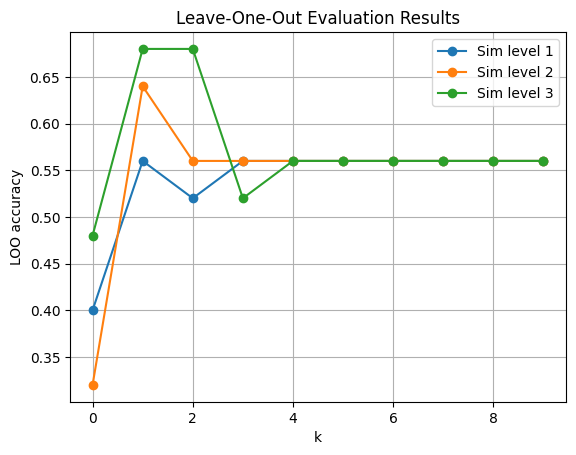

In [23]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mu = generate_capacity(enumerate_permute(x[0].unsqueeze(0))[0])

    print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = FuzzLOO(
            C = KNNFuzz(input_dimension=x.size(1),mu=mu, k=k, sim=S1), 
            DS = (x, label),
            mu=mu
        )
    l1.append(res)
    print(f"SimLevel1: {res}")
    # Sim level 2
    res = FuzzLOO(
            C = KNNFuzz(input_dimension=x.size(1),mu=mu, k=k, sim=S2), 
            DS = (x, label),
            mu=mu
        )
    l2.append(res)
    print(f"SimLevel2: {res}")

    # Sim level 3
    res = FuzzLOO(
            C = KNNFuzz(input_dimension=x.size(1),mu=mu, k=k, sim=S3), 
            DS = (x, label),
            mu=mu
        )
    l3.append(res)
    print(f"SimLevel3: {res}\n")

    toc = time.time()
    print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", marker='o')
plt.plot(l2, label="Sim level 2", marker='o')
plt.plot(l3, label="Sim level 3", marker='o')

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel("k")
plt.title("Leave-One-Out Evaluation Results")
plt.grid()
plt.legend()